1

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.combine import SMOTETomek
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from sklearn.svm import SVC
# from joblib import Parallel, delayed

2

In [3]:
# ===== 1. Đọc dữ liệu =====
df_sample = pd.read_csv("online_shoppers_intention.csv")

In [4]:
df = df_sample.sample(frac = 1, random_state = 42)

3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12330 entries, 8916 to 7270
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType              

In [6]:
df['Revenue'] = df['Revenue'].map({True: 1, False: -1})

# ===== 3. One-hot encoding =====
df = pd.get_dummies(df, columns=['Month', 'VisitorType', 'Weekend'], drop_first=True)

# month_map = {
#     'Jan': 1,
#     'Feb': 2,
#     'Mar': 3,
#     'Apr': 4,
#     'May': 5,
#     'June': 6,
#     'Jul': 7,
#     'Aug': 8,
#     'Sep': 9,
#     'Oct': 10,
#     'Nov': 11,
#     'Dec': 12
# }

# df = pd.get_dummies(df, columns=['VisitorType'],dtype = int)
# df['Month'] = df['Month'].map(month_map)
# df['Weekend'] = df['Weekend'].astype(bool).astype(int)
# # df['Revenue'] = df['Revenue'].astype(bool).astype(int)

# ===== 4. Xử lý missing value =====
df = df.dropna()

# ===== 5. Tách đặc trưng và nhãn =====
X = df.drop('Revenue', axis=1).values
y = df['Revenue'].values.astype(float)


In [6]:
# print(df['Revenue'].value_counts())
# df.describe()

In [7]:
# ===== 6. Train/Test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== 7. Chuẩn hóa =====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# ===== 8. RBF Kernel =====


# def rbf_kernel(x1, x2, sigma=1.0):
#     return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))


# def rbf_cal(a, b):
#     size_a = a.shape[0]
#     size_b = b.shape[0]
#     K = np.zeros((size_a, size_b))
#     for i in range(size_a):
#         for j in range(size_b):
#             K[i, j] = rbf_kernel(a[i], b[j])
#     return K
def rbf_cal(a, b, gamma):
    # Tính ||x - y||^2 = ||x||^2 + ||y||^2 - 2 x^T y
    a_norm = np.sum(a ** 2, axis=1).reshape(-1, 1)  # (n_samples_a, 1)
    b_norm = np.sum(b ** 2, axis=1).reshape(1, -1)  # (1, n_samples_b)
    K = np.exp(-(a_norm + b_norm - 2 * np.dot(a, b.T))*gamma)
    return K
# def rbf_cal(a, b, gamma, degree=3, coef0=1):
#     K = (np.dot(a, b.T)*gamma + coef0) ** degree
#     return K


# def rbf_cal(a, b, sigma=1.0):
#     # Tính ||x - y||^2 = ||x||^2 + ||y||^2 - 2 x^T y
#     a_norm = np.sum(a ** 2, axis=1).reshape(-1, 1)  # (n_samples_a, 1)
#     b_norm = np.sum(b ** 2, axis=1).reshape(1, -1)  # (1, n_samples_b)
#     K = np.exp(-(a_norm + b_norm - 2 * np.dot(a, b.T)) / (2 * sigma ** 2))
#     return K

# # Chia dữ liệu
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# smotetomek = SMOTETomek(random_state=42, sampling_strategy='all')
# X_resampled, y_resampled = smotetomek.fit_resample(X_train, y_train)
# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# ros = RandomOverSampler()
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# rus = RandomUnderSampler()
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
# X_resampled = X_train
# y_resampled = y_train 


print(pd.Series(y_resampled).value_counts())

# print("Các nhãn sau khi SMOTE:", np.unique(y_resampled))
# print("Các nhãn sau khi SMOTE:", np.unique(y_test))

-1.0    8297
 1.0    8297
Name: count, dtype: int64


In [9]:
# ===== 9. Tính ma trận Gram (train) =====
n_samples = X_resampled.shape[0]
gamma = 1/X_resampled.shape[1]
# K = np.zeros((n_samples, n_samples))
# for i in range(n_samples):
#     for j in range(n_samples):
#         K[i, j] = rbf_kernel(X_resampled[i], X_resampled[j])
        
K = rbf_cal(X_resampled, X_resampled, gamma)

In [10]:


# ===== 10. QP input =====
C = 1.0 # Regularization parameter
P = matrix(np.outer(y_resampled, y_resampled) * K) #ok check roi
q = matrix(-np.ones(n_samples)) #ok check roi
G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)])) #ok check roi
h = matrix(np.hstack([np.zeros(n_samples), np.ones(n_samples) * C])) #ok check roi
A = matrix(y_resampled.reshape(1, -1)) #ok check roi
b = matrix(0.0) #0.0 hay la 0
#b = matrix(np.zeros(1)) #ok check roi



In [11]:
# ===== 11. Solve QP =====
solvers.options['show_progress'] = False #chua biet
# solvers.options['abstol'] = 1e-10
# solvers.options['reltol'] = 1e-10 #chua biet
# solvers.options['feastol'] = 1e-10 #chua biet
solvers.options['abstol'] = 1e-5
solvers.options['reltol'] = 1e-5
solvers.options['feastol'] = 1e-7


sol = solvers.qp(P, q, G, h, A, b)
# print("số lượng sol:", len(sol))
# print(sol)
alphas = np.ravel(sol['x']) #ok check roi
# print("số lượng alpha:", len(alphas))

In [12]:
# ===== 12. Support vectors =====
threshold = 1e-5
sv = (alphas > threshold) & (alphas <= C)
sv_X = X_resampled[sv] #support vectors
sv_y = y_resampled[sv]
sv_alpha = alphas[sv]
# print("SV:", sv)

# 2. Xác định các Margin Vectors (0 < alpha_i < C)
margin_mask = (alphas > threshold) & (alphas < C - threshold)
margin_X = X_resampled[margin_mask]
margin_y = y_resampled[margin_mask]
# print("Số lượng support vectors:", len(sv_X))
# print("Giá trị alphas của SV:", sv_alpha)
# print("số lượng alphas của SV:", len(sv_alpha))
# print("Nhãn của SV:", np.unique(sv_y))

 Evaluation on Test Set:
Accuracy : 0.8548
Precision: 0.4667
Recall   : 0.3490
F1 Score : 0.3993


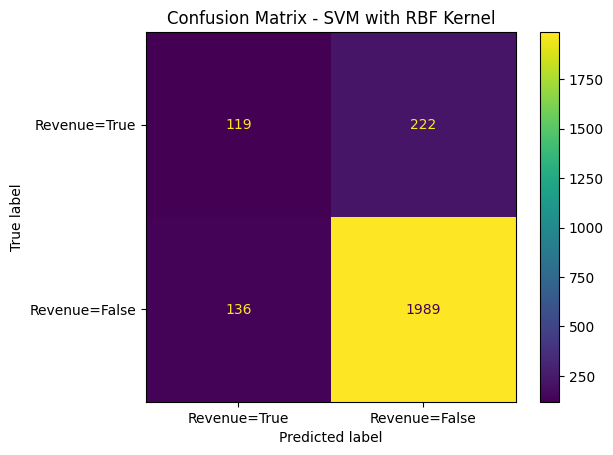

In [13]:






if len(margin_X) > 0:
    # print("bbbbbbbbbbbbbbbbbbbb")
    # K_ms = rbf_kernel(margin_X, sv_X, sigma=1.0)
    K_ms = rbf_cal(margin_X, sv_X)
    # Tính b cho các Margin Vectors
    a_s = sv_alpha * sv_y
    b = np.dot((margin_y - np.dot(K_ms, a_s)).T, np.ones(len(margin_X))) / len(margin_X)
else:
    # print("aaaaaaaaaaaaaaaaaaaaaaaa")
    # Fallback nếu không có margin vectors #can xem lai
    N = rbf_cal(sv_X[0:1], sv_X)
    a_s = sv_alpha * sv_y
    b = sv_y[0] - np.dot(N, a_s)[0]
    # b = sv_y[0] - np.dot(rbf_kernel(sv_X[0:1], sv_X, sigma=sigma), a_s)[0]

# ===== 13. Dự đoán =====
# hàm projext này bị sai, chạy ra kết quả có = 0
def project(x):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)
    # Tính K_bs: kernel giữa x và các support vectors
    K_bs = rbf_cal(x, sv_X)
    # K_bs = rbf_kernel(x, sv_X, sigma=1.0)
    
    # Tính y = K_bs * a_s + b
    # print("Đây là b:", np.unique(b))
    y = np.dot(K_bs, sv_alpha * sv_y) + b
    # Trả về mảng 1D
    # print("Các nhãn sau khi SMOTE:", np.unique(y))
    return y.ravel()
    # return y
    # return y[0]  # Trả về giá trị scalar nếu input là 1 điểm

def predict(X_test):
    # return np.sign([project(x) for x in X_test])
    return np.sign(project(X_test))
    # preds = Parallel(n_jobs=-1)(delayed(project)(x) for x in X_test)
    # return np.sign(np.array(preds).ravel())


# ===== 14. Dự đoán và đánh giá =====
y_pred = predict(X_test)
# print("Các nhãn sau khi SMOTE:", np.unique(y_pred))
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# print(pd.Series(y_test).value_counts())
print(f" Evaluation on Test Set:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# ===== 15. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Revenue=True", "Revenue=False"])
disp.plot()
plt.title("Confusion Matrix - SVM with RBF Kernel")
plt.show()


 Evaluation on Test Set:
Accuracy : 0.8629
Precision: 0.5031
Recall   : 0.7126
F1 Score : 0.5898


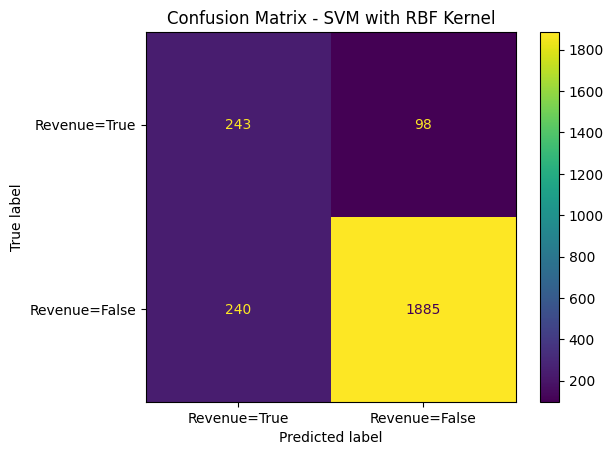

In [11]:
model = SVC(C=1.0, kernel='rbf', gamma = gamma)
# model = SVC(C=1.0, kernel='poly', degree=3, coef0=1, gamma=gamma)
model.fit(X_resampled, y_resampled.reshape(-1,))
# model.fit(X_train, y_train.reshape(-1,))

y_pre = model.predict(X_test)



# print("Các nhãn sau khi SMOTE:", np.unique(y_pre))
acu = accuracy_score(y_test, y_pre)
preci = precision_score(y_test, y_pre, pos_label=1)
reca = recall_score(y_test, y_pre, pos_label=1)
f1s = f1_score(y_test, y_pre, pos_label=1)

# print(pd.Series(y_resampled).value_counts())
# print(pd.Series(y_test).value_counts())
print(f" Evaluation on Test Set:")
print(f"Accuracy : {acu:.4f}")
print(f"Precision: {preci:.4f}")
print(f"Recall   : {reca:.4f}")
print(f"F1 Score : {f1s:.4f}")

# ===== 15. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pre, labels=[1, -1])
abc = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Revenue=True", "Revenue=False"])
abc.plot()
plt.title("Confusion Matrix - SVM with RBF Kernel")
plt.show()
